In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
with open('names.txt','r') as w:
    names = w.read()
    names = names.splitlines()

In [127]:
len(names)

32033

In [ ]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos= {s:i for i,s in stoi.items()}
print(stoi)
print(itos)

In [ ]:
def build_dataset(words):
    block_size = 3 #context length / how many chars do we need to predict the next word
    x, y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape,y.shape)
    return x, y

# split our dataset into train, dev and test
import random
random.seed(42)
random.shuffle(names)

n1 = int(0.7*len(names))
n2 = int(0.9*len(names))

xtr, ytr = build_dataset(names[:n1])
xdev, ydev = build_dataset(names[n1:n2])
xtest, ytest = build_dataset(names[n2:])

Now we embedd our 27 characters into a 2-D space.

In [ ]:
# for every 27 chars we have a 2-D space on which it is mapped on
C = torch.randn((27,2))

### Below we do some tensor gymnastics to see how effective pytorch indexing is and how we can simply index into C from x using C[x].

In [ ]:
xtr[:2].shape

In [ ]:
C[xtr[:2]].shape

Below we learn how one hot @ matrix is simply pulling out the ith row where i = 1 in one hot

In [ ]:
g = torch.Generator().manual_seed(4)
y = F.one_hot(torch.tensor(2,),num_classes=5).float()
x = torch.randn((5,2),generator=g)

In [ ]:
y

In [ ]:
x

In [ ]:
x[2]

In [ ]:
y.shape

In [ ]:
x.shape,y.shape

In [ ]:
y@x

looking up x in our embedding table C, just adds in a third dimesion which is 2 elements for each of X[1]. 

This causes every element of x to be represented by a len(2) vector

## Now we implement the embedding lookup table

In [ ]:
emb = C[xtr]
emb.shape

In [ ]:
emb.view(-1,6).shape

## To move our inputs to the next layer we would want to do 
1. emb @ W1 + b
2. But, we can't do that as emb and W1 are not shape compatible
3. So we do something familiar, i.e reshape/view of emb

In [ ]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [ ]:
# h = emb.view(32,6) @ W1 + b1 we change this in favour of below, as the magic -1 pops up.
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #also add a tanh to ensure ouputs btw -1 and 1, our non-linearity
h.shape

In [ ]:
#  again why log, if the probability is very high, we get the output close to zero, else if close to zero, we get hugely -ve.
loss = -probs[torch.arange(32),y].log().mean()
loss

## Lets make it respectable :)

In [195]:
# intialising all our embeddings, layers and biases
n_embd = 10
n_hidden = 200
vocab_size = len(stoi) 
block_size = 3

g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g) * 5/3 / ((n_embd*block_size)**0.5)  #kaiming initialisation
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size,generator=g) * 0

# batch-norm params
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

# Total params
parameters = [C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.numel() for p in parameters))

# enable gradient tracking
for p in parameters:
    p.requires_grad = True

12297


This is great way to get the total number of parameters.

In [ ]:
# forward pass
emb = C[x]
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)

## The below is a manual implemenation of negative log-likelihood loss or cross entropy loss, highly inefficient
# counts = logits.exp()
# probs = counts / counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(32),y].log().mean()

loss = F.cross_entropy(logits,y) # we can always replace the manual implementation of cross entropy with the direct funtion call, as its much faster
loss

Here we're trying to find a good learning rate.

In [ ]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs

In [160]:
batch_size = 32
lri = []
lossi = []

In [ ]:
plt.plot(lri,lossi)
# As we can see that we can find a good learning rate which comes to around -1.0, or 10^-1 = 0.1
# So 0.1 is a good learning rate.

In [196]:
for i in range(10000):

    # minibatch initialisation
    ix = torch.randint(0,xtr.shape[0],(batch_size,))

    # forward pass
    emb = C[xtr[ix]]
    hpreact = emb.view(-1,30) @ W1 + b1

    # we implement batchnorm and then add a BN gain + Bn bias so that the network can shift the gaussian distribution around on its own. -> scale and shift
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact = bngain*((hpreact-bnmeani) / bnstdi)  + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits,ytr[ix]) 
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()


    # Update
    # lr = lrs[i]
    # lr = 10**-2/(1+i*(10**-3))
    lr = 0.1 if i < 70000 else 0.01
    lri.append(lr)
    for p in parameters:
        p.data += -lr * p.grad
    
    # # trac stats
    # lri.append(lre[i])
    lossi.append(loss.item())

    # print(f"{loss.item():.4f}")
    # break
    if i % 1000 == 0:
        print(loss.item())


3.3168883323669434
2.577650785446167
2.5112223625183105
2.5045273303985596
2.922590494155884
2.0659847259521484
1.8299839496612549
2.3936543464660645
2.3888497352600098
2.457491159439087


In [197]:
with torch.no_grad():
    emb = C[xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [198]:
bnstd_running[:,:10]

tensor([[1.8270, 1.3480, 1.6302, 1.6242, 1.7820, 1.7557, 1.2954, 1.5389, 1.6835,
         1.3016]])

In [199]:
bnstd[:,:10]

tensor([[1.8690, 1.3551, 1.6514, 1.6372, 1.7714, 1.7949, 1.3141, 1.5421, 1.6946,
         1.3035]])

In [114]:
torch.tensor(lossi).view(-1,1000).shape

torch.Size([100, 1000])

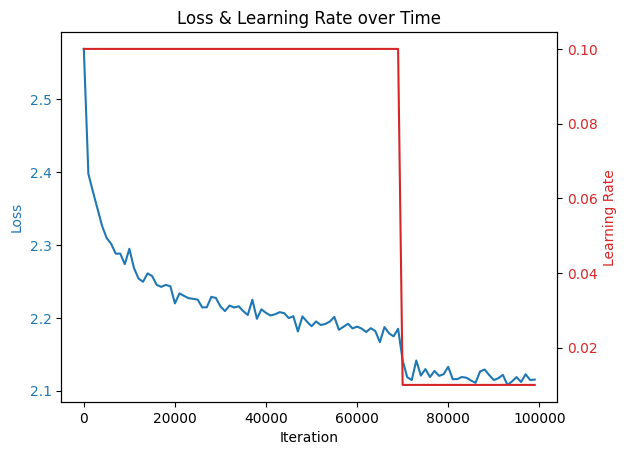

In [123]:
# Prepare your averaged loss and matching x-values
loss_avg = torch.tensor(lossi).view(-1, 1000).mean(1)
steps = torch.arange(len(loss_avg)) * 1000  # x-axis in iterations

# Make a figure with two y-axes
fig, ax1 = plt.subplots()

# First y-axis for loss
color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color=color)
ax1.plot(steps, loss_avg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Second y-axis for LR
ax2 = ax1.twinx()
color = 'tab:red'
lri_avg = torch.tensor(lri).view(-1, 1000).mean(1)
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(steps, lri_avg, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Loss & Learning Rate over Time')
plt.show()

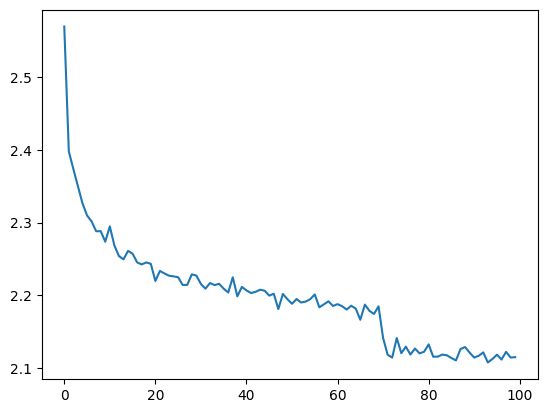

In [124]:
# when we implement LR decay
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

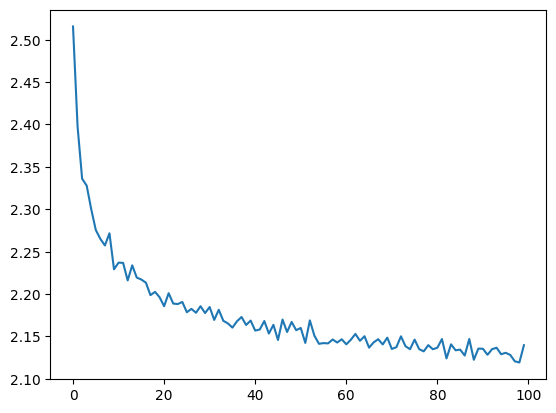

In [ ]:
# old plot with no lr decay
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

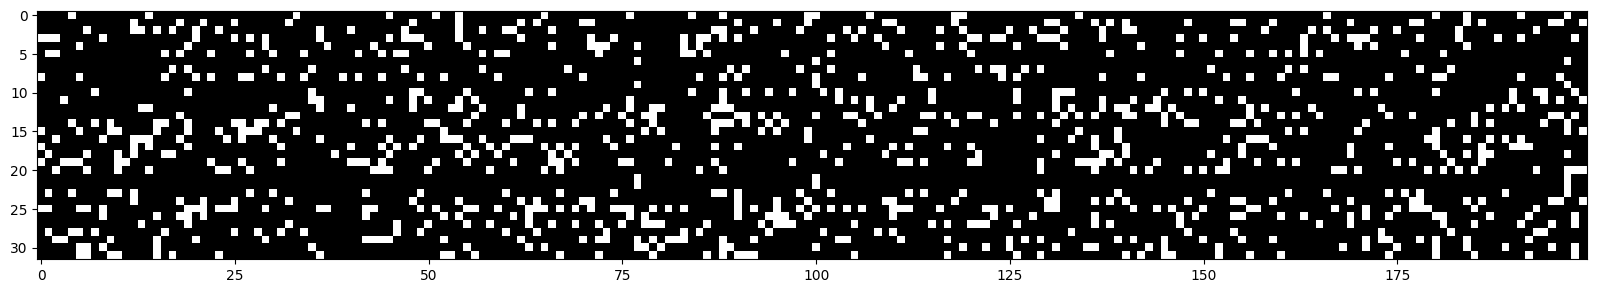

In [200]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()> 0.9,cmap='gray',interpolation='nearest')

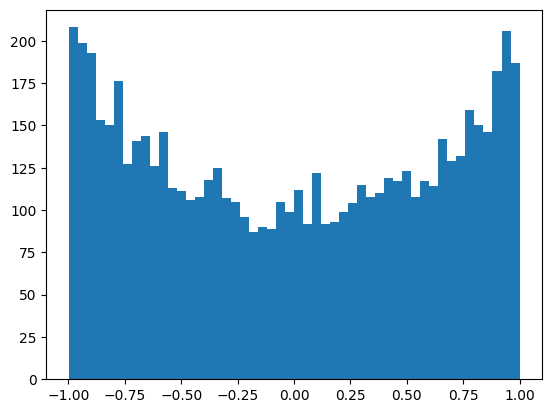

In [201]:
plt.hist(h.view(-1).tolist(),bins=50);

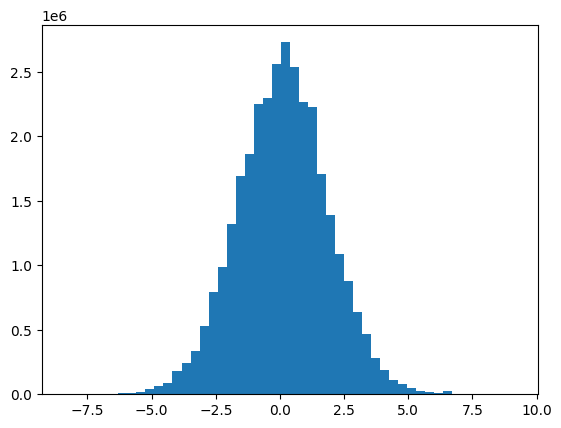

In [203]:
plt.hist(hpreact.view(-1).tolist(),bins=50);

In [ ]:
param_names = ['Embedding_lookup','W1','b1','W2','b2']
hyperparams: dict[str, float]
hyperparams = {name:p.shape for name,p in zip(param_names,parameters)}
hyperparams['Total_params'] = sum(p.numel() for p in parameters)
hyperparams['lr'] = lr
hyperparams['context_lenght'] = len(context)
hyperparams['batch_size'] = batch_size
hyperparams

In [ ]:
# training loss
emb = C[xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits,ytr)
loss

In [ ]:
# dev loss
emb = C[xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2 
loss = F.cross_entropy(logits,ydev)
loss